# Keras-Triplet-loss-MNIST
Train a Keras model using the semi-hard Triplet Loss (tensorflow) function on MNIST dataset

**Disclaimer**: This script is based on the example of Siamese network provided by **Keras-team** found [here](https://github.com/keras-team/keras/blob/master/examples/mnist_siamese.py).

## Resources
* Keras 2.1.6
* Tensorflow 1.8.0

## Triplet Loss explained:

![alt text](naive_implementation/triplet_loss_viz.png "Logo Title Text 1")

Figures taken from paper introducing Facenet(1). **Figure 2** represents the general idea of encoding images into a series of numbers much smaller than the image's size.

**Figure 3** presents the manner of training the network to differentiate between intra-class and inter-class cases. By pairing the images into triplet pairs of *Anchor-Positive* and *Anchor-Negative*, the network learns the distribution of images from each class with respect to all other classes.


Let's import some necessary functions

In [1]:
## dataset
from keras.datasets import mnist

## for Model definition/training
from keras.models import Model, load_model
from keras.layers import Input, Flatten, Dense, concatenate,  Dropout
from keras.optimizers import Adam

from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint

## required for semi-hard triplet loss:
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import dtypes
import tensorflow as tf

## for visualizing 
import matplotlib.pyplot as plt, numpy as np
from sklearn.decomposition import PCA
import h5py
import os
from google.colab import drive
drive.mount('/content/drive/')


print(os.getcwd())

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
/content


In [288]:
data=np.load("/content/drive/My Drive/Colab Notebooks/olivetti_faces.npy")
target=np.load("/content/drive/My Drive/Colab Notebooks/olivetti_faces_target.npy")

In [289]:
data=np.load("/content/drive/My Drive/Colab Notebooks/olivetti_faces.npy")
new_data=data
new_target=target
#adding extra datas
from matplotlib.image import imread
vivek_image="/content/drive/My Drive/Colab Notebooks/vivek"
for image in os.listdir(vivek_image):
   print(str(image))
   img = imread('/content/drive/My Drive/Colab Notebooks/vivek/'+str(image)).astype('float32')*1/255
   np.reshape(img,(1,64, 64))
   new_data=np.append(new_data,img)
new_data=np.reshape(new_data, (410,64, 64))
for n in range(10):

     new_target=np.append(new_target,41)


vivek4.jpg
vivek1.jpg
vivek6.jpg
vivek2.jpg
vivek7.jpg
vivek9.jpg
vivek5.jpg
vivek8.jpg
vivek3.jpg
vivek0.jpg


[[ 9  5 53 53]]


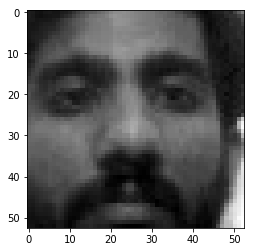

In [290]:
import cv2
face_cascade = cv2.CascadeClassifier('/content/drive/My Drive/Colab Notebooks/haarcascade_frontalface_default.xml') 
#gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  
    # Detects faces of different sizes in the input image 
   
img = imread('/content/drive/My Drive/Colab Notebooks/vivek/vivek1.jpg')
#.astype('uint8')


faces = face_cascade.detectMultiScale(img, 1.3, 5, 0) 
print(faces) 
for (x,y,w,h) in faces: 
        # To draw a rectangle in a face  
        #cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,0),2)  
        plt.imshow(img[y:y+h, x:x+w],cmap='gray')



In [291]:
X=new_data.reshape(new_data.shape[0],64,64,1)
new_target.shape

(410,)

24

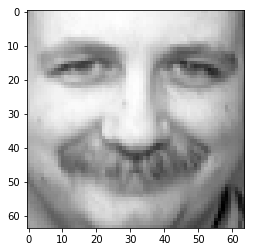

In [276]:
plt.imshow(new_data[240],cmap='gray')
new_target[240]

In [292]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(X,new_target,test_size=.2)
print(x_train.shape)

(328, 64, 64, 1)


### include the necessary functions for triplet loss:
** (from TF libraries) **

In [9]:
def pairwise_distance(feature, squared=False):
    """Computes the pairwise distance matrix with numerical stability.

    output[i, j] = || feature[i, :] - feature[j, :] ||_2

    Args:
      feature: 2-D Tensor of size [number of data, feature dimension].
      squared: Boolean, whether or not to square the pairwise distances.

    Returns:
      pairwise_distances: 2-D Tensor of size [number of data, number of data].
    """
    pairwise_distances_squared = math_ops.add(
        math_ops.reduce_sum(math_ops.square(feature), axis=[1], keepdims=True),
        math_ops.reduce_sum(
            math_ops.square(array_ops.transpose(feature)),
            axis=[0],
            keepdims=True)) - 2.0 * math_ops.matmul(feature,
                                                    array_ops.transpose(feature))

    # Deal with numerical inaccuracies. Set small negatives to zero.
    pairwise_distances_squared = math_ops.maximum(pairwise_distances_squared, 0.0)
    # Get the mask where the zero distances are at.
    error_mask = math_ops.less_equal(pairwise_distances_squared, 0.0)

    # Optionally take the sqrt.
    if squared:
        pairwise_distances = pairwise_distances_squared
    else:
        pairwise_distances = math_ops.sqrt(
            pairwise_distances_squared + math_ops.to_float(error_mask) * 1e-16)

    # Undo conditionally adding 1e-16.
    pairwise_distances = math_ops.multiply(
        pairwise_distances, math_ops.to_float(math_ops.logical_not(error_mask)))

    num_data = array_ops.shape(feature)[0]
    # Explicitly set diagonals to zero.
    mask_offdiagonals = array_ops.ones_like(pairwise_distances) - array_ops.diag(
        array_ops.ones([num_data]))
    pairwise_distances = math_ops.multiply(pairwise_distances, mask_offdiagonals)
    return pairwise_distances

def masked_maximum(data, mask, dim=1):
    """Computes the axis wise maximum over chosen elements.

    Args:
      data: 2-D float `Tensor` of size [n, m].
      mask: 2-D Boolean `Tensor` of size [n, m].
      dim: The dimension over which to compute the maximum.

    Returns:
      masked_maximums: N-D `Tensor`.
        The maximized dimension is of size 1 after the operation.
    """
    axis_minimums = math_ops.reduce_min(data, dim, keepdims=True)
    masked_maximums = math_ops.reduce_max(
        math_ops.multiply(data - axis_minimums, mask), dim,
        keepdims=True) + axis_minimums
    return masked_maximums

def masked_minimum(data, mask, dim=1):
    """Computes the axis wise minimum over chosen elements.

    Args:
      data: 2-D float `Tensor` of size [n, m].
      mask: 2-D Boolean `Tensor` of size [n, m].
      dim: The dimension over which to compute the minimum.

    Returns:
      masked_minimums: N-D `Tensor`.
        The minimized dimension is of size 1 after the operation.
    """
    axis_maximums = math_ops.reduce_max(data, dim, keepdims=True)
    masked_minimums = math_ops.reduce_min(
        math_ops.multiply(data - axis_maximums, mask), dim,
        keepdims=True) + axis_maximums
    return masked_minimums

## Define our Triplet Loss

In [10]:
def triplet_loss_adapted_from_tf(y_true, y_pred):
    del y_true
    margin = 1.
    labels = y_pred[:, :1]

 
    labels = tf.cast(labels, dtype='int32')

    embeddings = y_pred[:, 1:]

    ### Code from Tensorflow function [tf.contrib.losses.metric_learning.triplet_semihard_loss] starts here:
    
    # Reshape [batch_size] label tensor to a [batch_size, 1] label tensor.
    # lshape=array_ops.shape(labels)
    # assert lshape.shape == 1
    # labels = array_ops.reshape(labels, [lshape[0], 1])

    # Build pairwise squared distance matrix.
    pdist_matrix = pairwise_distance(embeddings, squared=True)
    # Build pairwise binary adjacency matrix.
    adjacency = math_ops.equal(labels, array_ops.transpose(labels))
    # Invert so we can select negatives only.
    adjacency_not = math_ops.logical_not(adjacency)

    # global batch_size  
    batch_size = array_ops.size(labels) # was 'array_ops.size(labels)'

    # Compute the mask.
    pdist_matrix_tile = array_ops.tile(pdist_matrix, [batch_size, 1])
    mask = math_ops.logical_and(
        array_ops.tile(adjacency_not, [batch_size, 1]),
        math_ops.greater(
            pdist_matrix_tile, array_ops.reshape(
                array_ops.transpose(pdist_matrix), [-1, 1])))
    mask_final = array_ops.reshape(
        math_ops.greater(
            math_ops.reduce_sum(
                math_ops.cast(mask, dtype=dtypes.float32), 1, keepdims=True),
            0.0), [batch_size, batch_size])
    mask_final = array_ops.transpose(mask_final)

    adjacency_not = math_ops.cast(adjacency_not, dtype=dtypes.float32)
    mask = math_ops.cast(mask, dtype=dtypes.float32)

    # negatives_outside: smallest D_an where D_an > D_ap.
    negatives_outside = array_ops.reshape(
        masked_minimum(pdist_matrix_tile, mask), [batch_size, batch_size])
    negatives_outside = array_ops.transpose(negatives_outside)

    # negatives_inside: largest D_an.
    negatives_inside = array_ops.tile(
        masked_maximum(pdist_matrix, adjacency_not), [1, batch_size])
    semi_hard_negatives = array_ops.where(
        mask_final, negatives_outside, negatives_inside)

    loss_mat = math_ops.add(margin, pdist_matrix - semi_hard_negatives)

    mask_positives = math_ops.cast(
        adjacency, dtype=dtypes.float32) - array_ops.diag(
        array_ops.ones([batch_size]))

    # In lifted-struct, the authors multiply 0.5 for upper triangular
    #   in semihard, they take all positive pairs except the diagonal.
    num_positives = math_ops.reduce_sum(mask_positives)

    semi_hard_triplet_loss_distance = math_ops.truediv(
        math_ops.reduce_sum(
            math_ops.maximum(
                math_ops.multiply(loss_mat, mask_positives), 0.0)),
        num_positives,
        name='triplet_semihard_loss')
    
    ### Code from Tensorflow function semi-hard triplet loss ENDS here.
    return semi_hard_triplet_loss_distance

### Define our base_model

having the structure
![alt text](images/base_network.png "Logo Title Text 1")

In [11]:
def create_base_network(image_input_shape, embedding_size):
    """
    Base network to be shared (eq. to feature extraction).
    """
    input_image = Input(shape=image_input_shape)

    x = Flatten()(input_image)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(embedding_size)(x)

    base_network = Model(inputs=input_image, outputs=x)
    #plot_model(base_network, to_file='base_network.png', show_shapes=True, show_layer_names=True)
    return base_network

### Loading the training/validation/testing DATA, as well as some other parameters

In [293]:
if __name__ == "__main__":
    # in case this scriot is called from another file, let's make sure it doesn't start training the network...

    batch_size = 300
    epochs = 350
    train_flag = True  # either     True or False

    embedding_size = 64

    no_of_components = 2  # for visualization -> PCA.fit_transform()

    step = 10

    # The data, split between train and test sets
  #  (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    #x_train /= 255.
    #x_test /= 255.
    input_image_shape = (64, 64, 1)
    x_val = x_test[:20, :, :]
    y_val = y_test[:20]

(20, 64, 64, 1)

### Instantiate the base network and define our model

We use the base network to define our final architecture:
![alt text](images/model.png "Logo Title Text 1")

### We use an Input layer to pass the label information (concatenated to the embeddings) to the the semi-hard triplet loss function.

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
input_label (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
model_18 (Model)                (None, 64)           549184      input_image[0][0]                
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 65)           0           input_label[0][0]                
                                                                 model_18[1][0]            

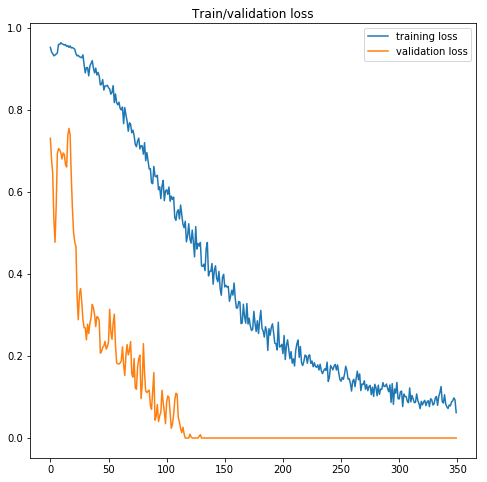

In [296]:
    # Network training...
    if train_flag == True:
        base_network = create_base_network(input_image_shape, embedding_size)
        input_images = Input(shape=input_image_shape, name='input_image') # input layer for images
        input_labels = Input(shape=(1,), name='input_label')    # input layer for labels
        embeddings = base_network([input_images])               # output of network -> embeddings
        labels_plus_embeddings = concatenate([input_labels, embeddings])  # concatenating the labels + embeddings

        # Defining a model with inputs (images, labels) and outputs (labels_plus_embeddings)
        model = Model(inputs=[input_images, input_labels],
                      outputs=labels_plus_embeddings)

        model.summary()
        plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

        # train session
        opt = Adam(lr=0.0001)  # choose optimiser. RMS is good too!

        model.compile(loss=triplet_loss_adapted_from_tf,
                      optimizer=opt)

        filepath = "semiH_trip_MNIST_v13_ep{epoch:02d}_BS%d.hdf5" % batch_size
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, period=25)
        callbacks_list = [checkpoint]

        # Uses 'dummy' embeddings + dummy gt labels. Will be removed as soon as loaded, to free memory
        dummy_gt_train = np.zeros((len(X), embedding_size + 1))
        dummy_gt_val = np.zeros((len(x_val), embedding_size + 1))

        x_train = np.reshape(X, (len(X), X.shape[1], X.shape[1], 1))
        x_val = np.reshape(x_val, (len(x_val), X.shape[1], X.shape[1], 1))

        H = model.fit(
            x=[X,new_target],
            y=dummy_gt_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=([x_val, y_val], dummy_gt_val),
            callbacks=callbacks_list)
        
        plt.figure(figsize=(8,8))
        plt.plot(H.history['loss'], label='training loss')
        plt.plot(H.history['val_loss'], label='validation loss')
        plt.legend()
        plt.title('Train/validation loss')
        plt.show()
    else:

        #####
        model = load_model('semiH_trip_MNIST_v13_ep25_BS256.hdf5',
                                        custom_objects={'triplet_loss_adapted_from_tf':triplet_loss_adapted_from_tf})

### Testing if the network learned the right thing...

1. Make an empty network
2. Loop over the trained model and copy weights
3. Obtain predictions (embeddings) for test set
4. Obtain PCA decomposition
5. Visualize the separation...

In [297]:
    # Test the network

    # creating an empty network
    testing_embeddings = create_base_network(input_image_shape,
                                             embedding_size=embedding_size)
    x_embeddings_before_train = testing_embeddings.predict(np.reshape(x_test, (len(x_test), 64, 64, 1)))
    # Grabbing the weights from the trained network
    for layer_target, layer_source in zip(testing_embeddings.layers, model.layers[2].layers):
        weights = layer_source.get_weights()
        layer_target.set_weights(weights)
        del weights

In [88]:
model = load_model('semiH_trip_MNIST_v13_ep350_BS256.hdf5',
                                        custom_objects={'triplet_loss_adapted_from_tf':triplet_loss_adapted_from_tf})

In [298]:
from sklearn.neighbors import KNeighborsClassifier
def fit_nearest_neighbor(img_encoding, img_class):
  classifier = KNeighborsClassifier(n_neighbors=5)
  classifier.fit(img_encoding, img_class)
  return classifier


In [299]:
e=testing_embeddings.predict(np.reshape(X, (len(X), 64, 64, 1)))
target = np.squeeze(new_target)
classifier = fit_nearest_neighbor(e,target)

1

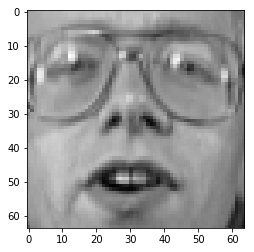

In [224]:
plt.imshow(data[14], cmap='gray')
target[14]

In [302]:
p=testing_embeddings.predict(np.reshape(img,(1,64, 64, 1)))

k = classifier.predict(p)
print(k)


[41]


2

array([[[0.8235294 , 0.8352941 , 0.81960785, ..., 0.84705883,
         0.8235294 , 0.827451  ],
        [0.83137256, 0.84705883, 0.8235294 , ..., 0.8745098 ,
         0.85882354, 0.8509804 ],
        [0.8235294 , 0.8156863 , 0.83137256, ..., 0.8235294 ,
         0.8352941 , 0.85490197],
        ...,
        [0.53333336, 0.53333336, 0.5176471 , ..., 0.34901962,
         0.31764707, 0.34509805],
        [0.5058824 , 0.5294118 , 0.54509807, ..., 0.30980393,
         0.2784314 , 0.4117647 ],
        [0.5019608 , 0.52156866, 0.5411765 , ..., 0.27450982,
         0.27450982, 0.35686275]]], dtype=float32)

(401, 64, 64, 1)

In [301]:
img = imread('/content/drive/My Drive/Colab Notebooks/viektest.jpg').astype('float32')/255
#img=np.reshape(img,(1,64, 64))


### Network learned how to separate the images based on their class!